## Import Library

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
'''------Reading files------'''
import os

'''------Audio preprocessing------'''
from pydub import AudioSegment

'''------Manipulating data------'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
'''-----image related-------'''
import cv2
import matplotlib.pyplot as plt
'''------Loading the audio------'''
import librosa
import IPython
'''------Loading the model------'''
from tensorflow.keras.models import load_model

## Load File

In [19]:
from pydub import AudioSegment
import numpy as np
import librosa

def audioPreprocessing(file):
    # Load the entire MP3 file
    song = AudioSegment.from_mp3(file)
    
    # Convert the entire audio to an array of samples
    samples = np.array(song.get_array_of_samples())
    arr = np.array(samples).astype(np.float32) / 32768  # Normalize 16-bit samples
    
    # Resample the entire audio to 11025 Hz
    arr = librosa.core.resample(y=arr, orig_sr=song.frame_rate, target_sr=11025, res_type='kaiser_best')
    
    return arr


In [20]:
# Feature Extraction
import re
def key_scale_finder(y,sr):
    pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    key = librosa.feature.chroma_stft(y=y,sr=sr).sum(axis=1).argmax()
    if re.search("\#$",pitches[key]):
        scale = "minor"
    else:
        scale = "major"
    return scale,pitches[key]

In [21]:
def feature_1d(y,sr):

    f = [] 
    
    scale,key= key_scale_finder(y,sr)
    f.append(scale) 
    f.append(key)
    
    # tempo
    tempo = librosa.beat.tempo(y=y,sr=sr)[0]
    f.append(tempo)  
    
    # RMS
    #S, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms)
    rms_var = np.var(rms)
    f.append(rms_mean)
    f.append(rms_var)
    
    # chroma features
    chroma = librosa.feature.chroma_stft(y=y,sr=sr)
    chroma_mean = np.mean(chroma)
    chroma_var = np.var(chroma)
    f.append(chroma_mean)
    f.append(chroma_var)
    
    # spectral centroid
    centroid = librosa.feature.spectral_centroid(y=y)
    centroid_mean = np.mean(centroid)
    centroid_var = np.var(centroid)
    f.append(centroid_mean)
    f.append(centroid_var)
    
    # spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y+0.01, sr=sr)
    rolloff_mean = np.mean(rolloff)
    rolloff_var = np.var(rolloff)
    f.append(rolloff_mean)
    f.append(rolloff_var)
    
    # zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y=y)
    zcr_mean = np.mean(zcr)
    zcr_var = np.var(zcr)
    f.append(zcr_mean)
    f.append(zcr_var)
    
    # tonnetz
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    tonnetz_mean = np.mean(tonnetz)
    tonnetz_var  = np.var(tonnetz)
    f.append(tonnetz_mean)
    f.append(tonnetz_var)
    
    #mel
    s = librosa.feature.melspectrogram(y=y, sr=sr)
    mel = librosa.amplitude_to_db(s, ref=np.max)
    mel_mean = np.mean(mel)
    mel_var = np.var(mel)
    f.append(mel_mean)
    f.append(mel_var)
    
    #mfcc
    mfcc = librosa.feature.mfcc(y=y,sr=sr,n_mfcc=20)
    m = len(mfcc)
    mfcc_mean = np.zeros((m,))
    mfcc_var = np.zeros((m,))
    for i in range(len(mfcc)):
        mfcc_mean[i] = np.mean(mfcc[i])
        mfcc_var[i]= np.var(mfcc[i])
        f.append(mfcc_mean[i])
        f.append(mfcc_var[i])
    
    return f

In [22]:
def moodString(f_pred):
    f_pre = ""
    if f_pred[0] == 0:
        f_pre = "Angry"
    elif f_pred[0] == 1:
        f_pre = "Happy"
    elif f_pred[0] == 2:
        f_pre = "Relaxed"
    elif f_pred[0] == 3:
        f_pre = "Sad"
    return f_pre

In [23]:
# Label Encoder
def labelEncode(features):
    # Scale
    if features[1] == 'major':
        features[1] = 0
    else:
        features[1] = 1
    
    # Key
    if features[2] == 'A':
        features[2] = 0
    elif features[2] == 'A#':
        features[2] = 1
    elif features[2] == 'B':
        features[2] = 2
    elif features[2] == 'C':
        features[2] = 3
    elif features[2] == 'C#': 
        features[2] = 4
    elif features[2] == 'D':
        features[2] = 5 
    elif features[2] == 'D#':
        features[2] = 6
    elif features[2] == 'E':
        features[2] = 7
    elif features[2] == 'F':
        features[2] = 8
    elif features[2] == 'F#':
        features[2] = 9
    elif features[2] == 'G':
        features[2] = 10
    elif features[2] == 'G#':
        features[2] = 11
    return features

In [24]:
def prediction1d(file):
    
    #crop the file
    arr = audioPreprocessing(file)
    
    #insert new test file to test set
    features = feature_1d(arr,22050)
    features.insert(0,file)
    
    df = pd.read_excel("D:/UM/Project/Mozartify/model/dataset/features/Features_extra.xlsx")
    X = df.drop('mood',axis=1)
    y = df['mood']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 13,  stratify = y)
    
    data = pd.DataFrame(features).T
    data.columns = X_test.columns
    X_test = pd.concat([X_test,data],axis=0)
    
    #Label Encoding
    X_test_encoded = X_test
    for i in range(len(X_test)):
        X_test_encoded.iloc[i] = labelEncode(X_test.iloc[i])
    
    #Feature Scaling
    X_test_scaled = X_test_encoded
    scaler = MinMaxScaler()
    X_test_scaled.iloc[:,1:] = scaler.fit_transform(X_test_encoded.iloc[:,1:])
    
    # Prediction
    model1D = load_model('D:/UM/Project/Mozartify/model/model/Features1D/Model/1d/Conv1D_Augmented.h5')
    
    prob = model1D.predict(X_test_scaled.iloc[len(X_test_scaled)-1,1:].to_numpy().astype('float32').reshape(1,57,1))
    pred_num = np.argmax(prob, axis = -1)
    pred = moodString(pred_num)
    
    return prob,pred


In [25]:
def feature2d(y,sr):
    
    # Spectrogram
    stft = librosa.stft(y)
    stft_db = librosa.amplitude_to_db(abs(stft))
    spec = stft_db
    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    # Mel
    s = librosa.feature.melspectrogram(y=y, sr=sr)
    mel = librosa.amplitude_to_db(s, ref=np.max)

    return spec, mfccs, mel

In [26]:
# Vote for most accuracte prediction
def get_majority(pred) :
    N = len(pred[0]) # num of examples
    vote = [] 
    for i in range(N) :
        elements = [j[i] for j in pred] # 3 Prediction results  using 3 different model
        elements = np.array(elements)
        uniq, freq = np.unique(elements, return_counts= True) # Count the occurence of unqiue result
        vote.append(uniq[np.argmax(freq)])# Choose the prediction with most occurence
    
    vote = np.array(vote)
    return vote

In [27]:
def prediction2d(file):
    arr = audioPreprocessing(file)
    f_spec, f_mfcc, f_mel = feature2d(arr,22050)

     # Resize the data
    f_spec_resized = cv2.resize(f_spec,(300,300))
    f_mfcc_resized = cv2.resize(f_mfcc,(600,120)) # (120,600)
    f_mel_resized = cv2.resize(f_mel,(400,300)) # (300,400)

    # Load data set
    mfcc_file = np.load("D:/UM/Project/Mozartify/model/dataset/features/Features2D/mfcc_train_test_agumented.npz")
    mfcc_test = mfcc_file['mfcc_test']
    y1_test = mfcc_file['y_test']

    spec_file = np.load("D:/UM/Project/Mozartify/model/dataset/features/Features2D/spec_train_test_agumented.npz")
    spec_test = spec_file['spec_test']
    y2_test = spec_file['y_test']

    mel_file = np.load("D:/UM/Project/Mozartify/model/dataset/features/Features2D/mel_train_test_agumented.npz")
    mel_test = mel_file['mel_test']
    y3_train = mel_file['y_test']

    # Put the sample into test set
    mfcc_test_new = np.concatenate([mfcc_test,f_mfcc_resized.reshape(1,120,600)],axis=0)
    spec_test_new = np.concatenate([spec_test,f_spec_resized.reshape(1,300,300)],axis=0)
    mel_test_new = np.concatenate([mel_test,f_mel_resized.reshape(1,300,400)],axis=0)

    # Feature scaling
    mfcc_test_new_scaled = (mfcc_test_new - np.mean(mfcc_test_new))/np.std(mfcc_test_new)
    spec_test_new_scaled = spec_test_new / np.amax(spec_test_new)
    mel_test_new_scaled = (mel_test_new - np.mean(mel_test_new))/np.std(mel_test_new)


    # Reshape the data
    N,row,col = spec_test_new_scaled.shape
    f_spec_reshaped = spec_test_new_scaled[spec_test_new_scaled.shape[0]-1].reshape((1,row,col,1))

    N,row,col = mfcc_test_new_scaled.shape
    f_mfcc_reshaped = mfcc_test_new_scaled[mfcc_test_new_scaled.shape[0]-1].reshape((1,row,col,1))

    N,row,col = mel_test_new_scaled.shape
    f_mel_reshaped = mel_test_new_scaled[mel_test_new_scaled.shape[0]-1].reshape((1,row,col,1)) 

    #Load 3 models
    model_spec = load_model("D:/UM/Project/Mozartify/model/model/Features1D/Model/2d/Conv2D_spec_agumented.h5")
    model_mfcc = load_model("D:/UM/Project/Mozartify/model/model/Features1D/Model/2d/Conv2D_mfcc_agumented.h5")
    model_mel = load_model("D:/UM/Project/Mozartify/model/model/Features1D/Model/2d/Conv2D_mel_agumented.h5")

    # Train 3 models
    y_prob1 = model_spec.predict(f_spec_reshaped)
    y_pred1 = np.argmax(y_prob1, axis= -1)

    y_prob2 = model_mfcc.predict(f_mfcc_reshaped)
    y_pred2 = np.argmax(y_prob2, axis= -1)

    y_prob3 = model_mel.predict(f_mel_reshaped)
    y_pred3 = np.argmax(y_prob3, axis= -1)

    y_pred = [y_pred1,y_pred2,y_pred3]
    pred_num = get_majority(y_pred)
    pred = moodString(pred_num)

    return pred, y_prob1, y_prob2, y_prob3

## Mood Prediction

In [34]:
file = "D:/UM/Project/Mozartify/model/dataset/sample songs/"+input('Please enter file name: ')
try:
    open(file)
except:
    print('file not exist!')
    quit()
    
model_num = 0
while(model_num!=1 or model_num!=2):
    model_num = int(input('Please enter 1 or 2 for choosing CNN1D and CNN2D model: '))
    if model_num==1 or model_num==2:
        break 
    else:
        print('Please choose from 1 or 2!')

IPython.display.display(IPython.display.Audio(file))

In [35]:
model_num=2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Filename: D:/UM/Project/Mozartify/model/dataset/sample songs/sample4.mp3
Predicted mood: Angry


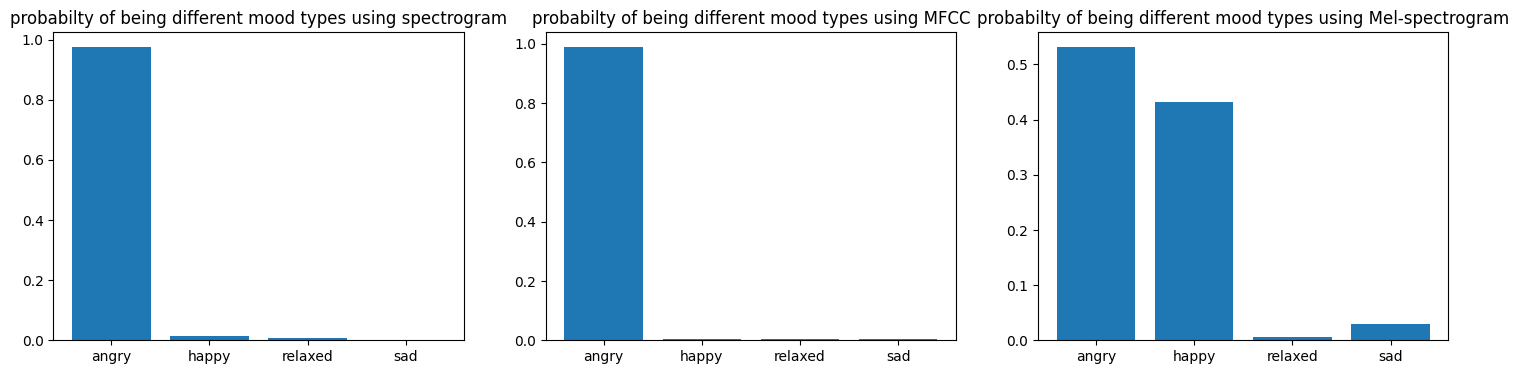

In [36]:
if model_num==1:
    prob,pred = prediction1d(file)

    print("Filename:",file)
    print("Predicted mood:",pred)
    
    types = ['angry','happy','relaxed','sad']  # For plotting the x-axis
    plt.figure(figsize=(12,4))
    plt.title('probabilty of being different mood types')
    plt.ylabel('probabilty')
    plt.bar(types, prob[0])
    plt.show()
    
else:
    pred, prob_spec, prob_mfcc, prob_mel = prediction2d(file)
    print("Filename:",file)
    print("Predicted mood:",pred)

    types = ['angry','happy','relaxed','sad']  # For plotting the x-axis
    f = plt.figure(figsize=(18,4))
    
    plt.subplot(1,3,1)
    plt.title('probabilty of being different mood types using spectrogram')
    plt.bar(types, prob_spec[0])
    
    plt.subplot(1,3,2)
    plt.title('probabilty of being different mood types using MFCC')
    plt.bar(types, prob_mfcc[0])

    plt.subplot(1,3,3)
    plt.title('probabilty of being different mood types using Mel-spectrogram')
    plt.bar(types, prob_mel[0])